# Clock Data Processing and Interpolation Report 

By Suzanne Thornton (776) 

January 2026

This report covers the data processing steps, especially interpolation, that are necessary to obtain a time series of clock ratios. We use examples of data collected in 2025. To obtain a clock ratio series, we assume there are shift data files corresponding to each clock in the ratio and a deglitched optical frequency comb data file. We use Python to process, format, and analyse the data. 

## Import and Setup

First, load (and install if necessary) the following Python packages.

In [75]:
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
import math 
from typing import List, Union, Optional
from astropy.time import Time
import missingno as msno

Then define functions to extract and load the comb data and each of the shift data files into the workspace. Note the last function in this section extracts information for the maser corrections. In this report, we restrict our attention to the ErYb comb. The process for the Ti Sapphire comb is similar but will require a different open comb file function. 

In [76]:
def open_ErYb_data(data_path):
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Yb_ErYb", "fb_Al_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    data.index = range(len(data))
 
    return data[list(types.keys())]

def open_shiftfile_Al(datapath):
    data = pd.read_csv(datapath, header=30, delimiter="\t", dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data

def open_shiftfile_Sr(datapath):
    data = pd.read_csv(datapath, header=24, delimiter="\t", dtype={1: str}, engine="python")

    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t",  dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
def open_maser_correction(datapath):
    data = pd.read_csv(datapath, header=1, delimiter=",", dtype={1: str}, engine="python")
 
    data.columns = ["date", "maser_offset"]
 
    data["date"] = data["date"].str.split("-").str.join("")
    data["maser_offset"] = data["maser_offset"].apply(float)
 
    return data

For this report, we make use of data that spans several different days of data collection. The list `days` below contains the dates for which we have complete data available for analysis. After setting the path to the folder containing the data files, we can now load the maser corrections data, the comb data, and the shift data into the workspace. 

In [77]:
days = [20250116, 20250124, 20250204, 20250227, 20250304, 20250307, 20250318]
days = list(map(str, days))
day_index = 6
path = "/Users/smt3/Documents/GitHub/2025 clock comparison data/"

maser_corrections = open_maser_correction(path + "daily maser offsets.csv")
data_ErYb = open_ErYb_data(path + days[day_index] + "/" + days[day_index] + "_Deglitched_ErYb_only.dat") 
shift_data_Al = open_shiftfile_Al(path + days[day_index] + "/" + days[day_index] + "_Alp_Freq_Shifts_ErYb.dat")
shift_data_Sr = open_shiftfile_Sr(path + days[day_index] + "/" + days[day_index] + "_clock_lock0.dat")
shift_data_Yb = open_shiftfile_Yb(path + days[day_index] + "/YbI_1_rerun.txt")

Next, we define functions that compute the optical frequecies for each clock based on the comb equation. We then apply these functions to the comb data object defined in the last step, i.e. `data_ErYb`. (If using the Ti Sapphire comb, these functions will need to be rewritten accordingly.) 

In [78]:
def compute_nuAl_ErYb(data):
    data["nuAl"] = -Decimal("105e6") + Decimal("560444") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Al_ErYb"]
    data["nuAl"] = Decimal(4) * data["nuAl"]   

def compute_nuSr_ErYb(data):
    data["nuSi"] = -Decimal("105e6") + Decimal("388752") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - Decimal("100e6")
    data["nuSr"] = (Decimal("1716882") / Decimal("777577")) * (data["nuSi"] - Decimal("216e6"))

def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"] 

compute_nuAl_ErYb(data_ErYb)
compute_nuSr_ErYb(data_ErYb)
compute_nuYb_ErYb(data_ErYb) 

Part of the data processing involves ensure that all values are read as high precision decimal values. For compatability, we must also ensure that the constants involved in the calculation of the ratio offset time series are all *Decimal* objects in Python. This includes each of the previous ratio averages to which we compare the current data's offset, the maser correction, and the gravitational shift corrections. The total correction factors are then computed for each of the three clocks. 

In [79]:
YbSrRatio2020 = Decimal("1.2075070393433378482") 
AlYbRatio2020 = Decimal("2.162887127516663703")
AlSrRatio2020 = Decimal("2.611701431781463025")
 
correction_condition = days[day_index] == maser_corrections["date"]
masercorrection = maser_corrections[correction_condition]["maser_offset"].apply(Decimal)

GR_shift_Al = Decimal("-8.114e-16") 
GR_shift_Yb = Decimal("-8.109e-16")
GR_shift_Sr = Decimal("10.660e-16")
GR_shift_sea_level = Decimal("-1798.501e-16")

total_correction_Yb = Decimal("1") + GR_shift_Yb + GR_shift_sea_level + masercorrection
total_correction_Sr = Decimal("1") + GR_shift_Sr + GR_shift_sea_level + masercorrection
total_correction_Al = Decimal("1") + GR_shift_Al + GR_shift_sea_level + masercorrection

## Data Processing 

### Visualizing Missing Values 
Data visualization is an important step to identify any unexpected patterns, including patterns of missing data. It is crucial that the individual time series used to compute the end result (a time series of ratio offsets) are visualized before they are combined and analyzed. This step also helps with the determination of an overlapping window of observation, discussed in the last subsection. 

First we take a look at the (three) time series corresponding to individual clock frequencies calculated from the comb equation and data. The `missingno` package is useful here since each of these series corresponds to the same time index, i.e. the same MJD values. To use this package we must convert the data types to floats and then create a Pandas data frame containing the MJD values and the comb frequency values corresponding to each clock (`nuAl`, `nuSr`, and `nuYb`). The spaces in the matrix of missingness plots represent missing values. Finally, we report the total number of missing values for each of the clock frequency series using the print statement.

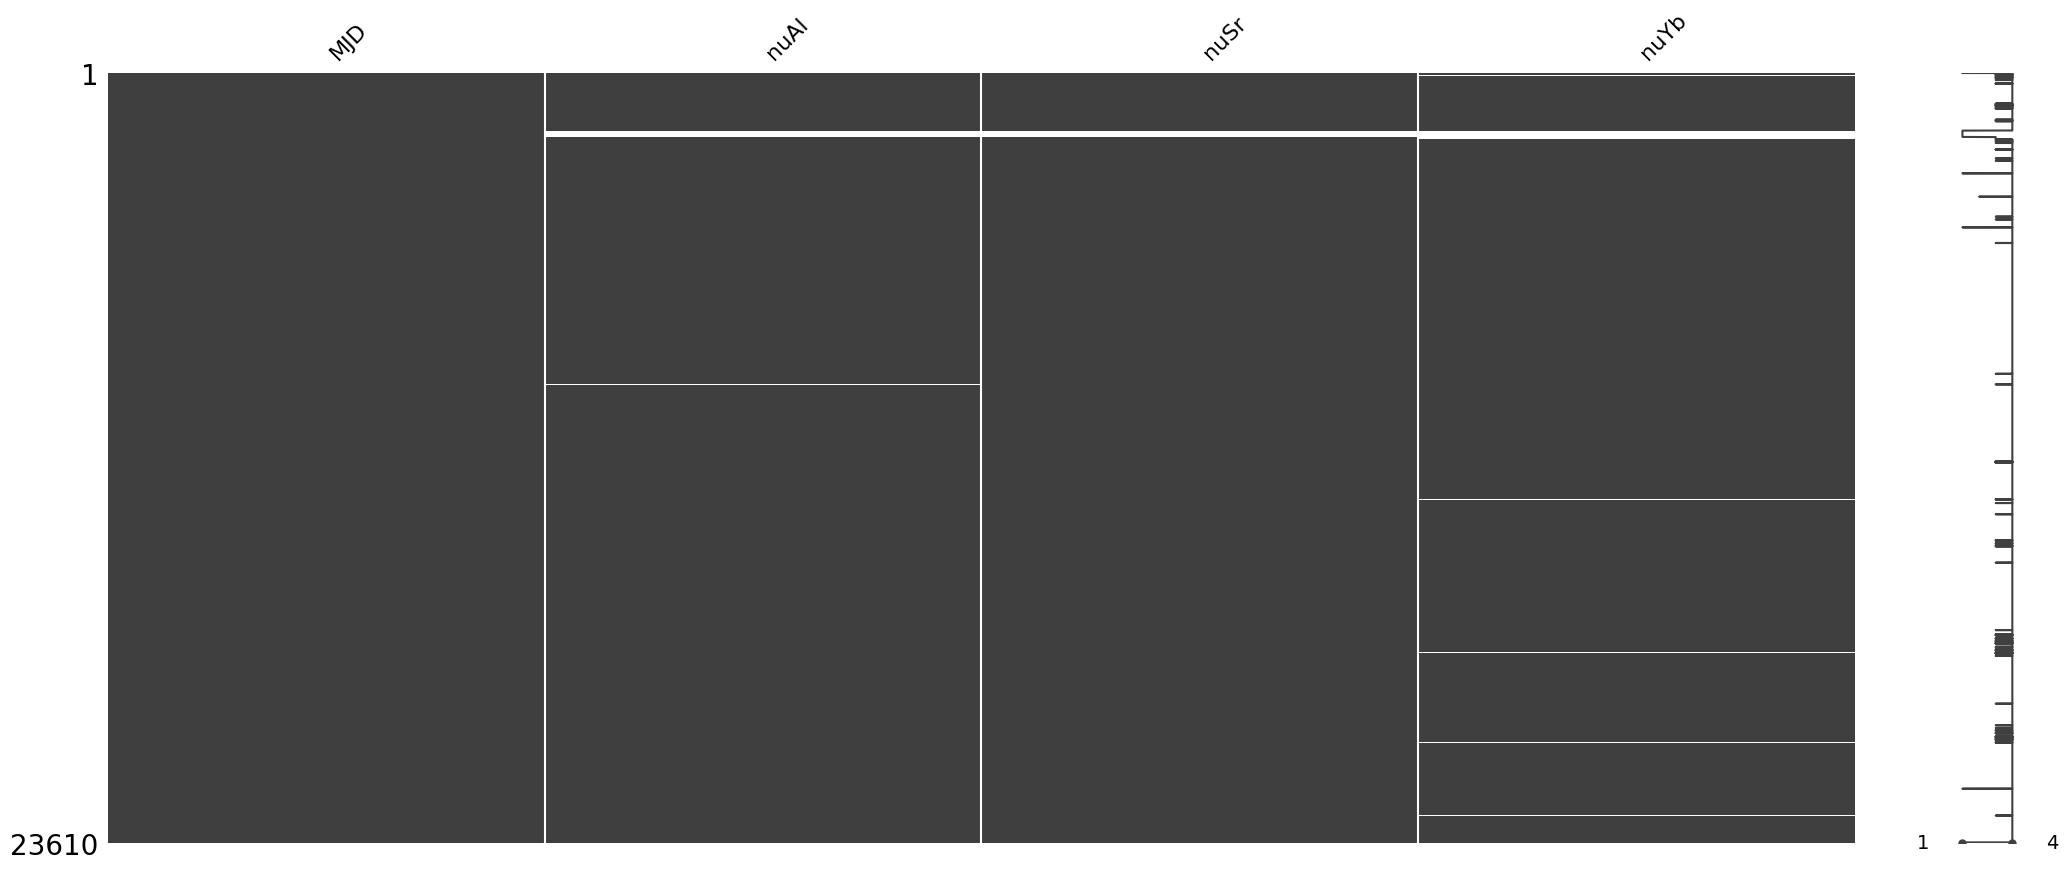

Missing Al comb nu:  233
Missing Sr comb nu:  203
Missing Yb comb nu:  417


In [80]:
common_mjd = data_ErYb["MJD"].astype(float)
nuAl = data_ErYb["nuAl"].astype(float)
nuSr = data_ErYb["nuSr"].astype(float)
nuYb = data_ErYb['nuYb'].astype(float)

msno.matrix(pd.DataFrame({'MJD': common_mjd, 'nuAl': nuAl, 'nuSr': nuSr, 'nuYb': nuYb}))
plt.show()

print("Missing Al comb nu: ", nuAl.isna().sum())
print("Missing Sr comb nu: ", nuSr.isna().sum())
print("Missing Yb comb nu: ", nuYb.isna().sum())

Next, we proceed to visualizing the missing values for each of the shift series. The `missingno` package is not as useful here because each clock's shift data corresponds to a unique time index. Instead, we  visualize the MJD indicies corresponding to each  clock's shift data along with the MJD indicies corresponding to non-missing comb frequecy values. 

In the code below, we use boolean indexing to extract a series of MJD values that correspond to non-missing clock shift values. We do the same thing for the comb data only here, the boolean condition checks that each of the clock comb frequency values (i.e. `nuAl`, `nuSr`, and `nuYb`) are non-missing. In the plot below, the default point size was decreased to make it easier to see the gaps or divets where the data is missing. 

As with the comb data, we report the total number of missing values for each of shift series using the print statement. Unlike with the comb data, these missing values correspond to the data that has been deemed as poor quality (i.e. the indicator function `IS_GOOD` is zero for these values). So the summary statement is not informing us about gaps in observations of the shift data, rather it is informing us about how much data was eliminated in the data filtering stage. 

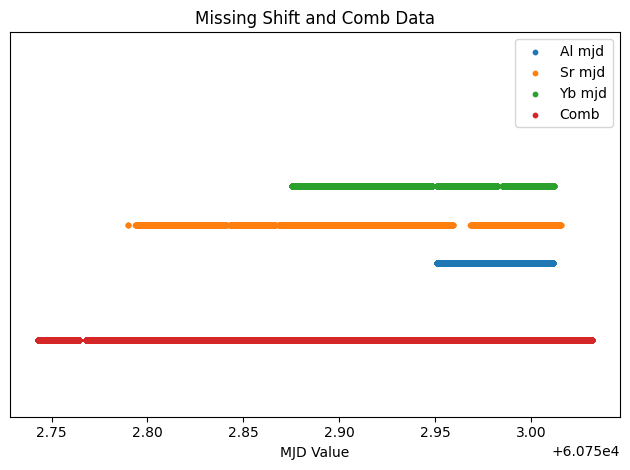

NA Al shift values:  81164
NA Sr shift values:  0
NA Yb shift values:  515


In [81]:
al_cond = ~shift_data_Al['shift'].isna()
Al_non_na = shift_data_Al[al_cond]
Al = pd.Series(Al_non_na['MJD'])

sr_cond = ~shift_data_Sr['shift'].isna()
Sr_non_na = shift_data_Sr[sr_cond]
Sr = pd.Series(Sr_non_na['MJD'])

yb_cond = ~shift_data_Yb['shift'].isna()
Yb_non_na = shift_data_Yb[yb_cond]
Yb = pd.Series(Yb_non_na['MJD']) 

comb_condition = (~data_ErYb['nuAl'].isna() & ~data_ErYb['nuSr'].isna() & ~data_ErYb['nuYb'].isna())
comb_full = data_ErYb[comb_condition]

plt.figure()
plt.scatter(Al, pd.Series([1] * len(Al)), label = 'Al mjd', s=10)
plt.scatter(Sr, pd.Series([1.25] * len(Sr)), label = 'Sr mjd', s=10)
plt.scatter(Yb, pd.Series([1.5] * len(Yb)), label = 'Yb mjd', s=10)
plt.scatter(pd.Series(comb_full['MJD']), pd.Series([0.5] * len(comb_full['MJD'])), label = 'Comb', s=10)
plt.ylim(0,2.5)
plt.yticks([])
plt.title('Missing Shift and Comb Data')
plt.xlabel("MJD Value")
plt.legend()
plt.tight_layout()
plt.show()

print("NA Al shift values: ", shift_data_Al['shift'].isna().sum())
print("NA Sr shift values: ", shift_data_Sr['shift'].isna().sum())
print("NA Yb shift values: ", shift_data_Yb['shift'].isna().sum())

In the example above, we can visually detect gaps of missing data in each series except for the one corresponding the Al+ shift values (blue). However, looking at the numerical summaries, we can tell that the Al+ shift data contains the most missing values. This is because a large chunk of the Al+ shift values were deemed to be too poor in quality in the data filtering stage that produced these data.  

### Extracting Quality Shift Data

The next step in the data processing stage is to ensure that we are only using shift values that are deemed quality data by the clock scientist. Each of the clock shift data files contains a column labeled `IS_GOOD` which indicates whether or not there was an issue with the reading of the data (0 indicates a known issue, 1 indicates no know issues). Based on the non-missing data for each clock's shift series, we further select a subset of each shift series that corresponds only to quality data. This may or may not decrease the number of points plotted in each of the clock's shift series. Looking at the printed numerical summary, we now see that there are no detected missing (i.e. NaN) data points. This is because any missing data has been discarded from the "good" series. 

Even though there are no NaN or poor quality data included in these series, we can tell from the plot that there are still "gaps" in the MJD values for most series where there is no recorded data. These gaps represent time stamps (i.e. MJD values) for which there is no recorded data. We consider the gaps in the next subsection where we determine the largest possible overlapping window of observations from which we can derive a ratio offset time series. 

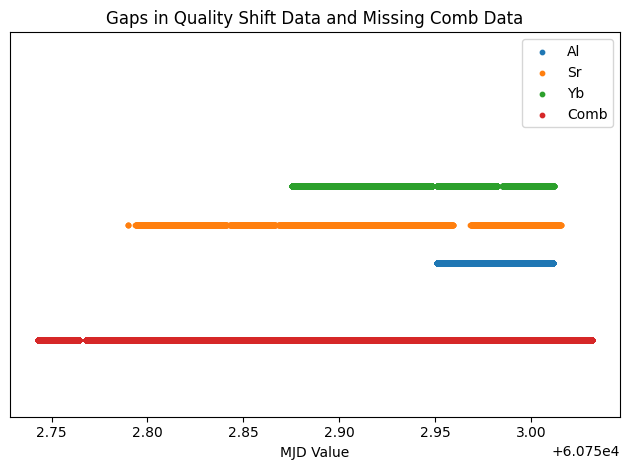

NA Al shift values:  0
NA Sr shift values:  0
NA Yb shift values:  0


In [82]:
good_condition_al = Al_non_na["IS_GOOD"] == 1
shift_data_Al_good = Al_non_na[good_condition_al].reset_index(drop=True, inplace = False)
Al_good = pd.Series(shift_data_Al_good['MJD'])

good_condition_sr = Sr_non_na["IS_GOOD"] == 1
shift_data_Sr_good = Sr_non_na[good_condition_sr].reset_index(drop=True, inplace = False)
Sr_good = pd.Series(shift_data_Sr_good['MJD'])

good_condition_yb = Yb_non_na["IS_GOOD"] == 1
shift_data_Yb_good = Yb_non_na[good_condition_yb].reset_index(drop=True, inplace = False)
Yb_good = pd.Series(shift_data_Yb_good['MJD']) 

plt.figure()
plt.scatter(Al_good, pd.Series([1] * len(Al_good)), label = 'Al', s=10)
plt.scatter(Sr_good, pd.Series([1.25] * len(Sr_good)), label = 'Sr', s=10)
plt.scatter(Yb_good, pd.Series([1.5] * len(Yb_good)), label = 'Yb', s=10)
plt.scatter(pd.Series(comb_full['MJD']), pd.Series([0.5] * len(comb_full['MJD'])), label = 'Comb', s=10)
plt.ylim(0,2.5)
plt.yticks([])
plt.title('Gaps in Quality Shift Data and Missing Comb Data')
plt.xlabel("MJD Value")
plt.legend()
plt.tight_layout()
plt.show()

## Visualize missing shift values for each clock's "good" data   
print("NA Al shift values: ", shift_data_Al_good['shift'].isna().sum())
print("NA Sr shift values: ", shift_data_Sr_good['shift'].isna().sum())
print("NA Yb shift values: ", shift_data_Yb_good['shift'].isna().sum())

### Determination of an Overlapping Window of Observations

As we can see in the last plot of the previous section, each of the time series begins and ends at different MJD values. We confirm this with the following code which displays the exact start and end MJD values for each of the clock shift series and the comb MJD series. 

In [83]:
len_comb = len(comb_full['MJD']) 
len_Al = len(shift_data_Al_good['shift'])        
len_Sr = len(shift_data_Sr_good['shift'])        
len_Yb = len(shift_data_Yb_good['shift'])

print("Comb start and end MJD: [", '{:0.11}'.format(comb_full['MJD'].iloc[0]), ', ', '{:0.11}'.format(comb_full['MJD'].iloc[len_comb-1]), ']')
print("Al good shift start and end MJD: [", shift_data_Al_good['MJD'].iloc[0], ', ', shift_data_Al_good['MJD'].iloc[len_Al-1], ']')
print("Sr good shift start and end MJD: [", shift_data_Sr_good['MJD'].iloc[0], ', ', shift_data_Sr_good['MJD'].iloc[len_Sr-1], ']')
print("Yb good shift start and end MJD: [", shift_data_Yb_good['MJD'].iloc[0], ', ', shift_data_Yb_good['MJD'].iloc[len_Yb-1], ']')

Comb start and end MJD: [ 60752.742818 ,  60753.031848 ]
Al good shift start and end MJD: [ 60752.9509491 ,  60753.0115278 ]
Sr good shift start and end MJD: [ 60752.78983432031 ,  60753.01555496421 ]
Yb good shift start and end MJD: [ 60752.87540139 ,  60753.01171893 ]


The next step is to determine a window of MJD values for which each time series overlaps in observations. To do this, we first identify the latest possible start time and the earliest possible end time among all the time series.

In [84]:
starts = [comb_full['MJD'].iloc[0], shift_data_Al_good['MJD'].iloc[0], shift_data_Sr_good['MJD'].iloc[0], shift_data_Yb_good['MJD'].iloc[0]] 
ends = [comb_full['MJD'].iloc[len_comb-1], shift_data_Al_good['MJD'].iloc[len_Al-1], shift_data_Sr_good['MJD'].iloc[len_Sr-1], shift_data_Yb_good['MJD'].iloc[len_Yb-1]] 

last_start_time = max(starts)
first_end_time = min(ends)

print("Last start time: ", last_start_time)
print("First end time: ", first_end_time)

Last start time:  60752.9509491
First end time:  60753.0115278


It may be desirable to select overlapping windows of sample observations in pairs rather than for all three clocks at once. This has the benefit of possibly including more data in any of the three ratio time series at the end. However, this approach is more involved and for the sake of demonstration, it is not included in this report.

Having identified the largest possible window of MJD values across all individual series (i.e. the latest start time to the earliest end time), it remains to trim down each series to this window only. The following functions are useful in this regard. 

The first function extracts an element from the `data` input that is as close to `target` as possible without going over, i.e. without creating an even later start time. The second is similar but extracts an element that is as close to the `target` as possible without going under, thereby creating an even earlier end time. 

In [85]:
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data.iloc[inx] < target:
            inx += 1
        else:
            return inx  

def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data.iloc[len(data)-inx] > target:
            inx += 1
        else:
            return len(data)-inx 

Now that we have the start and end times for the overlapping window of observations, i.e. `last_start_time` and `first_end_time`, and functions to extract the MDJ value as close to these time points as possible, we must apply these functions to each of the time series involved in calculating the ratio offset series. First, we apply these functions to the comb data, then we apply them to the clock shift data. 

After using the `ub_extract()` and `lb_extract()` functions on the MJD values of the comb data set resulting from the earlier data filtering stages, we create a new data frame, `comb`, that contains the MJD values and clock frequency values, `nuAl`, `nuSr`, and `nuYb`, within the time period between the last start time and the first end time over all data set. The index of the newly created `comb` data frame is reset for ease of reference in future stages of data processing. 

In [86]:
comb_start = ub_extract(target = last_start_time, data = comb_full['MJD'])  
comb_end = lb_extract(target = first_end_time, data = comb_full['MJD']) 

comb = pd.DataFrame()
comb["MJD"] = comb_full['MJD'].iloc[comb_start:comb_end] 
comb["nuAl"] = comb_full['nuAl'].iloc[comb_start:comb_end]
comb["nuSr"] = comb_full['nuSr'].iloc[comb_start:comb_end]
comb["nuYb"] = comb_full['nuYb'].iloc[comb_start:comb_end]
comb.reset_index(drop=True, inplace=True)

The same procedure is applied to each clock's filtered shift data. The resulting data frames are called `shift_data_Al`, `shift_data_Sr`, and `shift_data_Yb`. Now when we print the first and last MJD elements for each of these four new data frames, we see that they are almost exact matches.  

In [87]:
al_start = ub_extract(target = last_start_time, data = shift_data_Al_good["MJD"])
al_end = lb_extract(target = first_end_time, data = shift_data_Al_good["MJD"])  
shift_data_Al = shift_data_Al_good[al_start:al_end] 
shift_data_Al.reset_index(drop=True, inplace=True)

sr_start = ub_extract(target = last_start_time, data = shift_data_Sr_good["MJD"])
sr_end = lb_extract(target = first_end_time, data = shift_data_Sr_good["MJD"])  
shift_data_Sr = shift_data_Sr_good[sr_start:sr_end]
shift_data_Sr.reset_index(drop=True, inplace=True)

yb_start = ub_extract(target = last_start_time, data = shift_data_Yb_good["MJD"])
yb_end = lb_extract(target = first_end_time, data = shift_data_Yb_good["MJD"])  
shift_data_Yb = shift_data_Yb_good[yb_start:yb_end]
shift_data_Yb.reset_index(drop=True, inplace=True)

print("nuAl, nuSr, and nuYb start and end MJD: [", '{:0.11}'.format(comb["MJD"].iloc[0]), ', ', '{:0.11}'.format(comb["MJD"].iloc[len(comb["MJD"])-1]), ']')
print("Al good shift start and end MJD: [", shift_data_Al['MJD'].iloc[0], ', ', shift_data_Al['MJD'].iloc[len(shift_data_Al['MJD'])-1], ']')
print("Sr good shift start and end MJD: [", shift_data_Sr['MJD'].iloc[0], ', ', shift_data_Sr['MJD'].iloc[len(shift_data_Sr['MJD'])-1], ']')
print("Yb good shift start and end MJD: [", shift_data_Yb['MJD'].iloc[0], ', ', shift_data_Yb['MJD'].iloc[len(shift_data_Yb['MJD'])-1], ']')

nuAl, nuSr, and nuYb start and end MJD: [ 60752.950939 ,  60753.011522 ]
Al good shift start and end MJD: [ 60752.9509491 ,  60753.0115162 ]
Sr good shift start and end MJD: [ 60752.95094887931 ,  60753.01144822278 ]
Yb good shift start and end MJD: [ 60752.94844731 ,  60753.01152291 ]


This concludes the data processing stages; the next step is interpolation to align the different time series so they share a common time-based index. The clock-specific comb frequency time series are stored in the data frame `comb` whereas the clock-specific shift data are stored in the data frames `shift_data_Al`, `shift_data_Sr`, and `shift_data_Yb`.

## Interpolation

There are many, ever-increasing techniques for imputation and interpolation of time series data. This is an active area of statistical research motivated by applications across many fields including clock science, economics, engineering, and more. Furthermore, interpolation may take place in the time or frequency domain of time series data. Pavía-Miralles (2010) discusses both a temporal perspective and analysis in the frequency domain. In addition to providing a useful overview of common time series interpolation techniques, Lepot, Aubin, and Clemens (2017) also remark upon the assessment of uncertaintites that result from interpolation, noting that the law of propagation of uncertaintites does not apply in this case. In this report, we mainly restrict our focus to interpolation techniques within the time domain. We primarily focus on techniques that can be implemented with the Python `interpolate()` function from the `pandas` package though we extend our discussion to a more advanced interpolation technique at the end. 

### Re-format Data 

To apply interpolation techniques with the Python `interpolate()` function, it will be useful to have the individual time series indexed by datetime rather than by MJD. In the code below, this is accomplished via the `Time()` function within the `astropy.time` Python package. First, copies are made of each data frame containing a time series. Then, a new column containing the datetime is added to each of these new data frames. Finally, the index of each data frame is re-set to be the datetime column which will be important for the time-based interpolation technique presented in the next section. The final version of the clock shift data frames (`Al_shift`, `Sr_shift`, and `Yb_shift`) are simplified to contain only one column corresponding to the shift value.  

In [88]:
comb_datetime = comb.copy()
comb_datetime['datetime'] = Time(comb_datetime['MJD'], format = 'mjd').to_datetime()
comb_datetime = comb_datetime.set_index('datetime')

shift_data_Al_datetime = shift_data_Al.copy()
shift_data_Al_datetime['datetime'] = Time(shift_data_Al_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Al_datetime = shift_data_Al_datetime.set_index('datetime')

shift_data_Sr_datetime = shift_data_Sr.copy()
shift_data_Sr_datetime['datetime'] = Time(shift_data_Sr_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Sr_datetime = shift_data_Sr_datetime.set_index('datetime')

shift_data_Yb_datetime = shift_data_Yb.copy()
shift_data_Yb_datetime['datetime'] = Time(shift_data_Yb_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Yb_datetime = shift_data_Yb_datetime.set_index('datetime')

Al_shift = shift_data_Al_datetime['shift']
Sr_shift = shift_data_Sr_datetime['shift']
Yb_shift = shift_data_Yb_datetime['shift']

The last data processing step before we apply an interpolation technique is to merge the datetime indicies of the clock shift data with those indicies from the comb data frame. Since the optical frequency comb produces data that is more regularly obsered than the shift data, we will interpolate the shift data onto the datetime values indexing the comb data. This is a three step process that is applied to each of the clock shift data frames resulting from the previous steps. 

First, we idenify which datetime indices are contained in the comb data frame but not in, say, the Al+ shift data. We accomplish this with the `difference()` function and store the results in an object called `interp_times_Al`, for example. Second, we merge the `interp_times_Al` indices with the original, observed Al+ shift indicies using the `union()` function and then sort all of these values from smallest to largest. Third, we create the expanded shift data frame, say `Al_shift_expanded`, which includes the original shift data plus the datetime indicies that are found only in the comb data with NaN as the corresponding shift value. These steps are repeated for each of the shift data frames. 

In [89]:
interp_times_Al = comb_datetime.index.difference(Al_shift.index) 
long_Al_index = Al_shift.index.union(interp_times_Al).sort_values()
Al_shift_expanded = Al_shift.reindex(long_Al_index)

interp_times_Sr = comb_datetime.index.difference(Sr_shift.index) 
long_Sr_index = Sr_shift.index.union(interp_times_Sr).sort_values()
Sr_shift_expanded = Sr_shift.reindex(long_Sr_index)

interp_times_Yb = comb_datetime.index.difference(Yb_shift.index) 
long_Yb_index = Yb_shift.index.union(interp_times_Yb).sort_values()
Yb_shift_expanded = Yb_shift.reindex(long_Yb_index)

### Time-based Interpolation 
The `pandas` function [`interpolate()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html) provides versitile interpolation techniques that can apply to a data frame containing missing values. The processing completed in the previous section yields datetime indexed time series containing missing data corresponding to each clock's shift data. Because the data are time series observed at a very high resolution, we can use a time-based interpolation technique that interpolates missing shift values based on the given length of the time interval index. Because the result we desire requires a ratio of clock shift values and because we have indexed each of the shift time series with the datetime of the comb data, we extract only the shift values that correspond to the datetime indices of the comb data after performing the interpolation. Note the inclusion of an interpolation limit in the code below prevents interpolation over large gaps of missing data. The code below prevents interpolation over any gaps of 10 or more sequential missing values. Since the observations of the comb occur just about every second, this corresponds to gaps of about 10 seconds or more. The implementation of an interpolation limit means that there may be missing values in the target time series of clock ratio offset data.    

In [90]:
interp_method = 'time' 
interp_limit = 10

Al_shift_interpolated = Al_shift_expanded.interpolate(method=interp_method, limit=interp_limit)
Al_shift_final = Al_shift_interpolated[comb_datetime.index]

Sr_shift_interpolated = Sr_shift_expanded.interpolate(method=interp_method, limit=interp_limit)
Sr_shift_final = Sr_shift_interpolated[comb_datetime.index]

Yb_shift_interpolated = Yb_shift_expanded.interpolate(method=interp_method, limit=interp_limit)
Yb_shift_final = Yb_shift_interpolated[comb_datetime.index]

This approach calculates missing values by linearly interpolating among known values, but instead of using the integer position or value, this approaches uses the actual time difference to construct the interpolation formula: 
$y = y_0 + (y_1 - y_0)\frac{t - t_0 }{ t_1 - t_0},$
where $y_0$, $y_1$ are the known values surrounding the missing data, $t_0$, $t_1$ are the corresponding time index values, and $t$ is the time index of the missing value. 

Thus this method is suitable for time series data with irregular time intervals. Although the time intervals for the comb data are mostly regular, if we look carefully at the numerical summary of the differences between date time indices of subsequent pairs of observations below, we see the maximum difference is a little of three seconds, rather than one second. 

In [91]:
data = {
    "comb": comb_datetime.index.diff()
} 
mjd_diff = pd.DataFrame(data)

print(mjd_diff.describe())

                            comb
count                       4886
mean   0 days 00:00:01.071299877
std    0 days 00:00:00.141648872
min       0 days 00:00:01.036800
25%       0 days 00:00:01.036800
50%       0 days 00:00:01.036800
75%       0 days 00:00:01.036800
max       0 days 00:00:03.196800


In [92]:
#print(Al_shift_expanded.index)

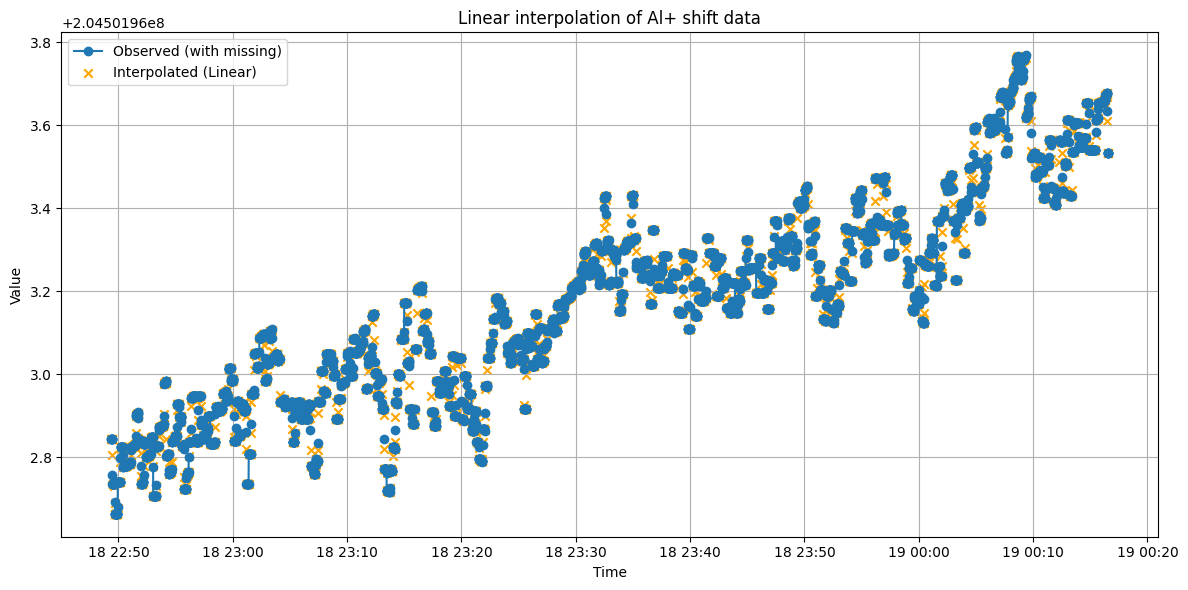

In [93]:
# Plot of linear interpolated Al shift data
plt.figure(figsize=(12, 6))
plt.plot(Al_shift_expanded, label='Observed (with missing)', marker='o', linestyle='-')
#plt.plot(Al_shift_final, label='Interpolated (Linear)', marker = 'x') #linestyle='--')
plt.scatter(Al_shift_final.index, Al_shift_final, label='Interpolated (Linear)', marker = 'x', c = 'orange') 
plt.legend()
plt.title('Linear interpolation of Al+ shift data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Kalman filter smoothing

Another time-based interpolation technique involves using a Kalman filter for smoothing to estimate missing values of time series data. The unobserved components (UC) model, also known as the structural time series model (STM), is fit to the time series data by characterizing its trend in a manner that is permitted to change with time. (The same can apply to seasonal and cyclical components of the time series though that is not likely applicable to this type of data.) This model is constructed in state space form so that a Kalman filter can be applied to make optimal predictions for unobserved states. [include math notation for state space form and regular form.] As with the time-based linear interpolation technique presented above, this approach can also be customized to avoid interpolating over large gaps of sequential missing values. Note that in contrast to the linear approach above, applying a Kalman smoothing approach does not require reformatting the data to have a date-time index. 

The strength of this approach is that it can capture gradual changes in trend [?]. The optimality of this approach depends on the appropriateness of assuming Gaussian noise [?]. This method may produce questionable estimates for the initial part of a time series. [why? sources?] [is there any reason to recommend this over the linear approach?]  

An example implementing the Kalman smoothing technique to compare it to the time-based linear approach is presented at the end of this document in the Appendix. 


### Other Interpolation Techniques 

The `pandas` `interpolate` function provides many different interpolation techniques. The source code for this function can be found on [GitHub](https://github.com/pandas-dev/pandas/blob/v2.3.1/pandas/core/generic.py#L8219-L8535). Here we limit our attention to those methods which can apply to one dimensional time series data with many observations and sharp points of changing trends as key characteristics. The assistance of generative AI (i.e. chatGPT) was employed in the following summaries of various `pandas`  interpolation methods. 

#### Pad and Nearest 

A couple rudimentary interpolation techniques worth mentioning include the `pad` method and `nearest` method. If `interp_method` is set to `pad`, a forward-fill approach replaces any missing value with the last known non-null value preceeding it. The method `nearest`, on the other hand, replaces each missing value with the value of the nearest known data point in index space. Figuratively, one may think of `pad` as analagous to water flowing forward and filling empty spaces, whereas 'nearest' is like a vote where the missing point becomes the value of its closest neighbor in time. While these are not the most sophisticated interpolation methods available, they are worth mentioning because of their popularity and ease (and speed) of implementation. 

#### Linear 

Setting `interp_method` to `linear` will implement linear one-dimensional interpolation. This interpolation technique treats all values of the series as if they are equally spaced, a condition that is worth verifying before applying. For time series data with regular time intervals, linear interpolation and time-based interpolation produce the same results. With irregular intervals, linear interpolation erroneously assumes equal spacing between points, producing misleading results. 

#### Cubic and Polynomial 

Quadratic, cubic, and other higher-order polynormal interpolation methods are also available options. If it is desired to fit a  polynomial with order greater than three, the order must be specified in addition to setting the method to `polynomial`. 

These interpolation approaches fit a smooth polynomial through the known data points and use this to estimate the missing values. Time-based polynomial interpolation requires resetting the datetime indices so they are treated numerically; i.e. datetime stamps must first be converted to floats (or back to MJD). It is worth noting that the computational cost of interpolation increases with the degree of the polynomial. 

There are spline versions of time, linear, and polynomial interpolation methods, which work in a piece-wise manner, fitting lines (or polynomials) between pairs of non-missing data points and using these piece-wise functions to interpolate the missing values. The methods discussed here instead fit a line or a polynomial to the entire data set and use this to infer missing values. 

## Analysis and Results 

Having processed and visualized the original data and interpolated the shift data so that it matches up with the observations of the comb data, we are now ready to derive the ratio offset time series data for analysis. Here, there are three ratio time series we will analyze and compare corresponding to each pair of the three clocks, Al+, Sr, and Yb. We will analyze these three ratio time series numerically and visually. 

### Deriving and Formating Ratio Data 

Before deriving the ratio time series, we first convert the values in each time series (those from the comb data frame and those corresponding to interpolated clock shift data) to type `Decimal`. This ensures that the calculations are preformed on high precision data. Once the individual time series are all Decimal types, we add the comb frequencies to the clock shift values and multiply by the respective correction factor for each clock. The use of `.iloc[]` in this part of the process extracts the single Decimal value series from the list resulting from this operation. Next, the three offset ratio time series are derived for the ratio between Al+ and Sr, Yb and Sr, and Al+ and Yb. In the following code block, the clock ratios' offsets are calculated based on comparison to the corresponding average ratio value from BACON (2021).

In [94]:
nuAl = [Decimal(i) for i in comb['nuAl']]
nuSr = [Decimal(i) for i in comb['nuSr']]
nuYb = [Decimal(i) for i in comb['nuYb']]

shiftAl = [Decimal(i) for i in Al_shift_final]
shiftSr = [Decimal(i) for i in Sr_shift_final]
shiftYb = [Decimal(i) for i in Yb_shift_final]

frequency_Al_ErYb = [((i + j) * total_correction_Al).iloc[0] for i, j in zip(nuAl, shiftAl)]
frequency_Sr_ErYb = [((i + j) * total_correction_Sr).iloc[0] for i, j in zip(nuSr, shiftSr)]
frequency_Yb_ErYb = [((i + j) * total_correction_Yb).iloc[0] for i, j in zip(nuYb, shiftYb)]

frequency_ratio_ErYb1 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Sr_ErYb)]
frequency_ratio_ErYb2 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb, frequency_Sr_ErYb)]
frequency_ratio_ErYb3 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Yb_ErYb)]

### Summary Statistics 

The two numerical summary statistics we present here are the mean and the Allen variance of the ratio offset time series. The `numpy` package contains a useful function `nanmean()` that will calculate the mean of the input data while ignoring any missing data. Rounded to five significant digits, the means for the ratios from this example data are shown below. 

In [95]:
print("Al+/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1)))
print("Yb/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2)))
print("Al+/Yb ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3)))

Al+/Sr ratio offset from BACON paper -1.1856E-16
Yb/Sr ratio offset from BACON paper -1.0808E-16
Al+/Yb ratio offset from BACON paper -1.4916E-17


The average offset for each of the three clock ratios using different interpolation techniques is compared in the table below.  

| Average offset | Al+/Sr | Yb/Sr | Al+/Yb |
| --- | --- | --- | --- |
| Time |  -1.1856E-16  |  -1.0808E-16  |  -1.4916E-17  |
| Linear |  -1.1874E-16  |  -1.0800E-16  |  -1.5164E-17  |
| Pad |  -1.1812E-16  |  -1.0730E-16  |  -1.5250E-17  |
| Nearest |  -1.1862E-16  |  -1.0827E-16  |  -1.4809E-17  |
| Cubic |  -1.1885E-16  |  -1.0841E-16  |  -1.4838E-17  |


For the Allen variance, we define the function `overlapping_avar_fn()` which computes the overlapping Allen variance of a time series of high precision decimal values. The first argument of this function, `y`, is the time series, and the argument `m` is a whole number representing the window size over which to calculate the Allen variance. To handle missing data, the function `clean_frequency_ratio()` prepares the time series for input into `overlapping_avar_fn()` by removing any "None" values or "NaNs" from the input list. Most of the missing data in these series is due to the interpolation limit set earlier; however, some of the missing values are due to the missing comb data which we explored initially in the "visualizing missing values" stage. 

In [96]:
def overlapping_avar_fn(y, m): 
    M = len(y)

    if M < 2 * m:
        raise ValueError(f"Length of input (M={M}) must be at least 2 * m (2 * {m} = {2 * m})")

    if any(isinstance(v, Decimal) and v.is_nan() for v in y):  
        raise ValueError("Input y contains NaN values.")
    
    if m <= 0:
        raise ValueError("m must be a positive integer")

    outer_sum = 0

    for j in range(0, M - 2 * m + 1):
        inner_sum = 0
        for i in range(j, j + m):
            inner_sum += y[i + m] - y[i]
        outer_sum += inner_sum ** 2

    result = outer_sum / (2 * m**2 * (M - 2 * m + 1))
    return result

def clean_frequency_ratio(frequency_ratio_data: List[Optional[Union[float, Decimal]]]) -> List[Union[float, Decimal]]:
    return [
        x for x in frequency_ratio_data
        if x is not None
        and not (
            (isinstance(x, float) and math.isnan(x)) or
            (isinstance(x, Decimal) and x.is_nan())
        )
    ]

After creating cleaned copies of the ratio data, the code below computes the Allen deviation (the square root of the Allen variance) of each time series over one third of the sample size of the series. Note the sample size of the series in this calculation does not include any missing data. 

In [97]:
clean_frequency_ratio_ErYb1 = clean_frequency_ratio(frequency_ratio_ErYb1)
clean_frequency_ratio_ErYb2 = clean_frequency_ratio(frequency_ratio_ErYb2)
clean_frequency_ratio_ErYb3 = clean_frequency_ratio(frequency_ratio_ErYb3)

print("Al+/Sr ADEV with tau=", math.floor(len(clean_frequency_ratio_ErYb1)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb1, math.floor(len(clean_frequency_ratio_ErYb1)/3)).sqrt()))
print("Yb/Sr ADEV with tau=", math.floor(len(clean_frequency_ratio_ErYb2)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb1, math.floor(len(clean_frequency_ratio_ErYb2)/3)).sqrt())) 
print("Al+/Yb ADEV with tau=", math.floor(len(clean_frequency_ratio_ErYb3)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb3, math.floor(len(clean_frequency_ratio_ErYb1)/3)).sqrt()))

Al+/Sr ADEV with tau= 1390 :  7.5332E-18
Yb/Sr ADEV with tau= 1286 :  7.0540E-18
Al+/Yb ADEV with tau= 1525 :  6.8614E-18


Below is a table and a plot comparing the ADEV for all three ratios from different interpolation techniques. 

| ADEV | Al+/Sr | Yb/Sr | Al+/Yb |
| --- | --- | --- | --- |
| Time |  7.5332E-18  |  7.0540E-18  |  6.8614E-18  |
| Linear |  7.5714E-18 |  7.1413E-18  |  6.8243E-18   |
| Pad |  7.3350E-18  |   6.8760E-18 |   6.8207E-18  |
| Nearest |  7.5264E-18  |  7.0411E-18  |  6.9457E-18  |
| Cubic |  7.5898E-18  |  7.1504E-18  |  7.0090E-18  |


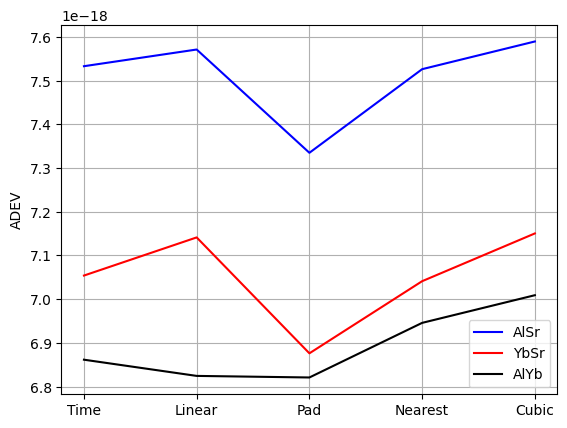

In [98]:
adev_data = {
    'AlSr': [7.5332E-18,7.5714E-18,7.3350E-18, 7.5264E-18, 7.5898E-18], 
    'YbSr': [7.0540E-18, 7.1413E-18, 6.8760E-18, 7.0411E-18, 7.1504E-18],
    'AlYb': [6.8614E-18, 6.8243E-18, 6.8207E-18, 6.9457E-18, 7.0090E-18]
}
adev_df = pd.DataFrame(adev_data)

x = ['Time', 'Linear', 'Pad', 'Nearest', 'Cubic']
colors = { 
    'AlSr': 'blue',
    'YbSr': 'red',
    'AlYb': 'black'
}

for col in adev_df.columns:
    plt.plot(x, adev_df[col], label=col, color=colors.get(col, 'black'))
plt.ylabel('ADEV')
plt.legend()
plt.grid(True)
plt.show() 

### Visualizations

Finally, we create scatter plots for the three resulting ratio time series. The plots display gaps over the time windows where no interpolation occured. The MJD values plotted along the horizontal axis correspond to the MJD values observed by the optical frequency comb. 

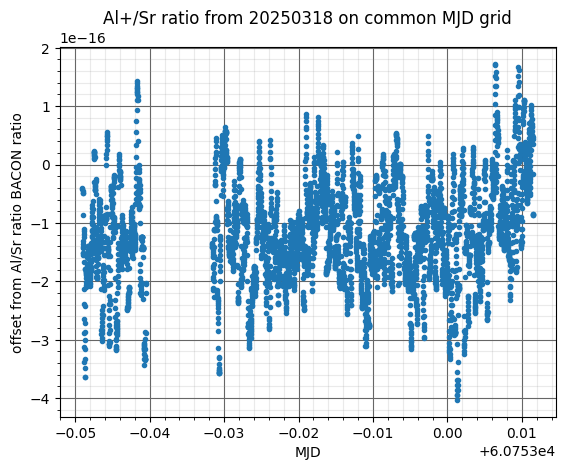

In [99]:
## Al+/Sr ratio offset  
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al+/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

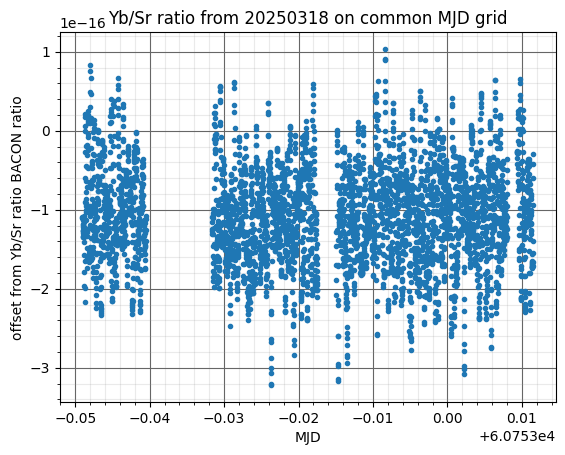

In [100]:
## Yb/Sr ratio offset  
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

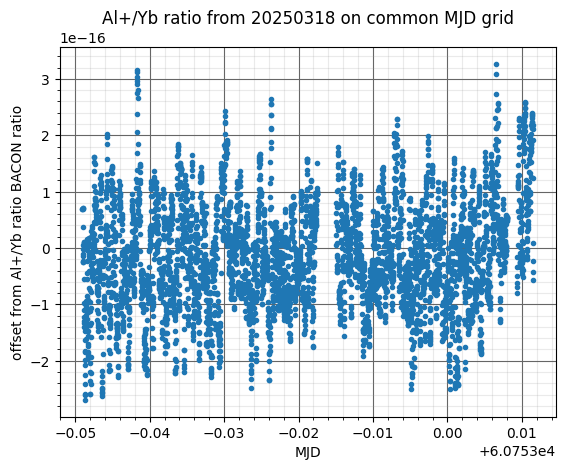

In [101]:
## Al+/Yb ratio offset  
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al+/Yb ratio BACON ratio")
plt.title("Al+/Yb ratio from " + days[day_index] + " on common MJD grid")
plt.show()

## References 

Boulder Atomic Clock Optical Network (BACON) Collaboration. (2021). Frequency Ratio Measurements at 18-digit Accuracy Using an Optical Clock Network. *Nature.* 591:564-569. doi:10.1038/s41586-021-03253-4.

Ercolani, Joanne. (2023, September 20). Unobserved Components Models. *Oxford Research Encyclopedia of Economics and Finance.* Retrieved 13 Oct. 2025. doi:10.1093/acrefore/9780190625979.013.896

Jalles, João Tovar. (June 19, 2009). Structural Time Series Models and the Kalman Filter: A Concise Review. *FEUNL Working Paper.* No. 541. doi:10.2139/ssrn.1496864

Lepot, Mathieu, Aubin, Jean-Baptiste, and Clemens, François H.L.R. (2017). Interpolation in Time Series: An Introductive Overview of Existing Methods, Their Performance Criteria and Uncertainty Assessment. *Water.* 9:796. doi:10.3390/w9100796.

Pavía-Miralles, Jose Manuel (2010). A Survey of Methods to Interpolate, Distribution and Extrapolate Time Series. *J. Service Science \& Management.* 449-463. doi:10.4236/jssm.2010.34051. 

## Appendix

### Interpolation with Kalman filtering

**Unobserved Components Model**

Trend plus noise moded:

$y_t = \mu_t + \varepsilon_t$


Local linear trend:

$\mu_t = \mu_{t-1} + \beta_{t-1} + \eta_t$ (level/trend equation)

$\beta_t = \beta_{t-1} + \zeta_t$ (slope equation)

where $\eta_t \sim N(0, \sigma_{\eta}^2)$ is uncorrelated with $\zeta_t \sim N(0, \sigma_{\zeta}^2)$. 

This model essentially represents the trend with a linear equation where the slope and intercept may vary over time. 


**State Space form of Local Linear UCM**

Measurement/observation equation: $y_t = \alpha_t + \varepsilon_t$,

Transition equation: $\alpha_t = \alpha_{t-1} + \xi_t$;

for $t=1,\dots,T$ where $\varepsilon_t \sim N(0, \sigma_{\varepsilon}^2)$ is uncorrelated with $\xi_t \sim N(0, \sigma_{\xi}^2)$. 

Here we use the Kalman filter to interpolate across three time series with missing values. Those time series are `Al_shift_expanded`, `Sr_shift_expanded`, and `Yb_shift_expanded` derived at the end of the data-processing step in the main text above. This technique requires the `statsmodels.api` Python package to make use of the `tsa.UnobservedComponents` model.

After importing the `statsmodels.api` Python package, the first step is to define a structural time series model, also known as the unobserved components model. The documentation for [`statsmodels`](https://www.statsmodels.org/stable/statespace.html) contains specific details about this modeling technique. The `local level` option fits a local level model with measurement equation $y_t = \mu_t + \varepsilon_t$ and transition equation $\mu_{t+1} = \mu_t + \eta_t$ where $\mu_t$ is the unobserved, time-dependent trend component of the observed time series $y_t$ with disturbance $\varepsilon_t$ and where $\eta_t$ is an additional noise term. This enables the model to capture gradual changes in the growth rate of the time series by permitting the observed and unobserved (trend) components of the time series to be non-stationary.  

In [102]:
import statsmodels.api as sm

Al_model = sm.tsa.UnobservedComponents(Al_shift_expanded, level='local level')
Sr_model = sm.tsa.UnobservedComponents(Sr_shift_expanded, level='local level')
Yb_model = sm.tsa.UnobservedComponents(Yb_shift_expanded, level='local level')

/Users/smt3/Documents/myvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/smt3/Documents/myvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/smt3/Documents/myvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Once the time series models have been defined, the limited-memory Broyden–Fletcher–Goldfarb–Shanno (lbfgs) algorithm is used to fit the model via maximum likelihood estimation. 

In [103]:
Al_result = Al_model.fit(method='lbfgs') 
Sr_result = Sr_model.fit(method='lbfgs')
Yb_result = Yb_model.fit(method='lbfgs')

Next we use the Kalman smoother to estimate the latent state of our unobserved components model. The Kalman smoothing step is triggered by applying the `smoothed_state` function to the results of the maximum likelihood fit. The result is a full smoothed path of the latent time-dependent state for the entire series, including where data is missing. Next the results are formatted as a Pandas series for further operations. 

In [104]:
Al_smoothed_level = Al_result.smoothed_state[0]
Sr_smoothed_level = Sr_result.smoothed_state[0]
Yb_smoothed_level = Yb_result.smoothed_state[0]  

Al_shift_interpolated = pd.Series(Al_smoothed_level, index=Al_shift_expanded.index)
Sr_shift_interpolated = pd.Series(Sr_smoothed_level, index=Sr_shift_expanded.index)
Yb_shift_interpolated = pd.Series(Yb_smoothed_level, index=Yb_shift_expanded.index)

The next bit of code effectively implements an interpolation limit as is done in the time-based linear interpolation section above. We define a function `detect_long_missing` that identifies any sequences of more than 10 consecutive missing values to exclude them from interpolation with the Kalman smoothing method. The final interpolated time series objects, `Al_shift_final`, `Sr_shift_final`, and `Yb_shift_final`, thus only contain missing values where there are long (more than about 10 seconds) periods of missing data, similar to above.

In [105]:
def detect_long_missing(data, max_len=10):
    mask = data.isna()
    long_gaps = pd.Series(False, index=data.index)

    start = None
    for i, val in enumerate(mask):
        if val and start is None:
            start = i
        elif not val and start is not None:
            if i - start > max_len:
                long_gaps[start:i] = True
            start = None
    if start is not None and len(data) - start > max_len:
        long_gaps[start:] = True

    return long_gaps

Al_long_gap_mask = detect_long_missing(Al_shift_expanded, max_len=10)
Al_shift_interpolated[Al_long_gap_mask] = np.nan
Al_shift_final = Al_shift_interpolated[comb_datetime.index]

Sr_long_gap_mask = detect_long_missing(Sr_shift_expanded, max_len=10)
Sr_shift_interpolated[Sr_long_gap_mask] = np.nan
Sr_shift_final = Sr_shift_interpolated[comb_datetime.index]

Yb_long_gap_mask = detect_long_missing(Yb_shift_expanded, max_len=10)
Yb_shift_interpolated[Yb_long_gap_mask] = np.nan
Yb_shift_final = Yb_shift_interpolated[comb_datetime.index]

An important point is that the initial values of the interpolated time series may need to be discarded using this approach. The latent state estimates resulting from the Kalman smoothing technique are often unreliable at the beginning of the time series. [citation?] For example, the two plots below display the `Al_shift_final` interpolated series for all of the time points compared with the same series excluding the first five time points. Clearly, the initial points are unreliable and should not be included in deriving the ratio time series for ultimate analysis.

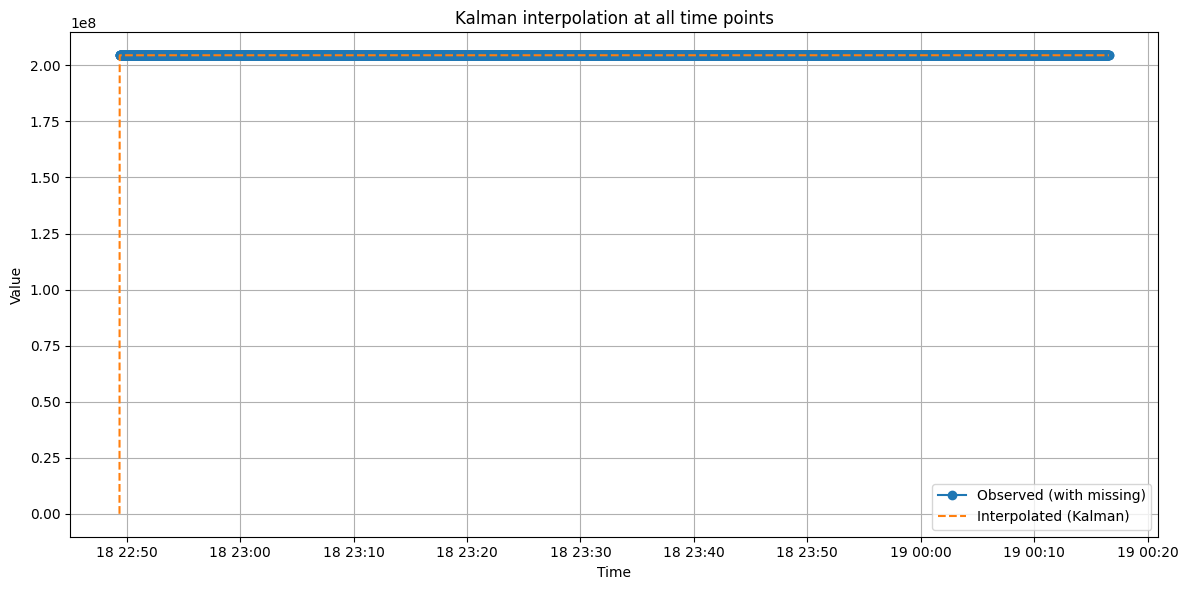

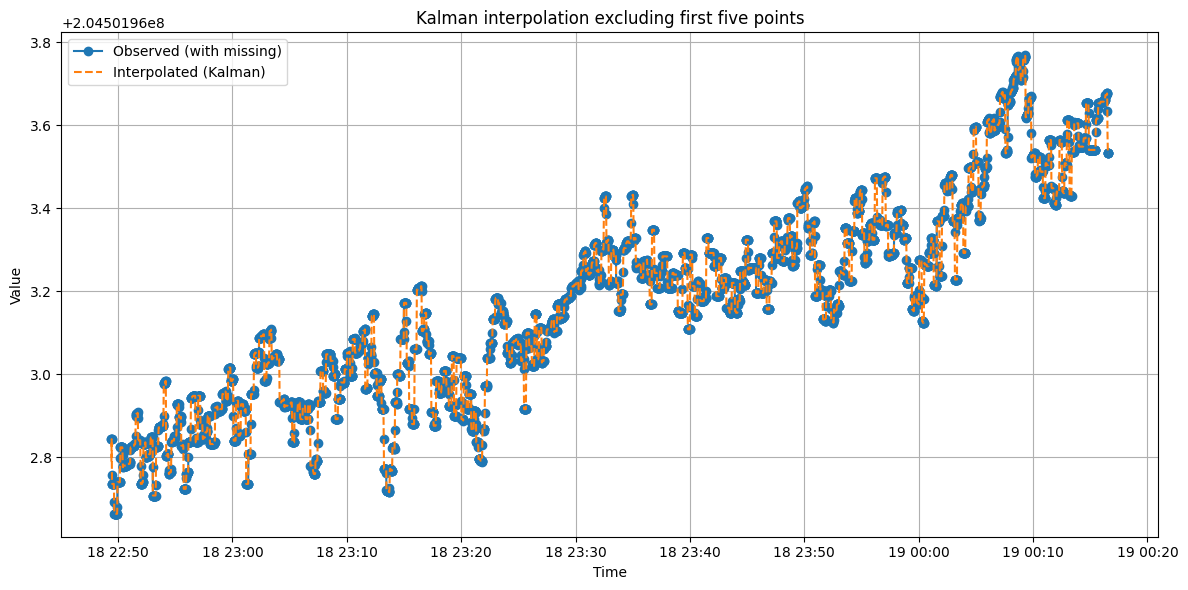

In [106]:
# Plot including all time points 
plt.figure(figsize=(12, 6))
plt.plot(Al_shift_expanded, label='Observed (with missing)', marker='o', linestyle='-')
plt.plot(Al_shift_final, label='Interpolated (Kalman)', linestyle='--')
plt.legend()
plt.title('Kalman interpolation at all time points')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot exluding first five points 
plt.figure(figsize=(12, 6))
plt.plot(Al_shift_expanded[4:], label='Observed (with missing)', marker='o', linestyle='-')
plt.plot(Al_shift_final[4:], label='Interpolated (Kalman)', linestyle='--')
plt.legend()
plt.title('Kalman interpolation excluding first five points')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

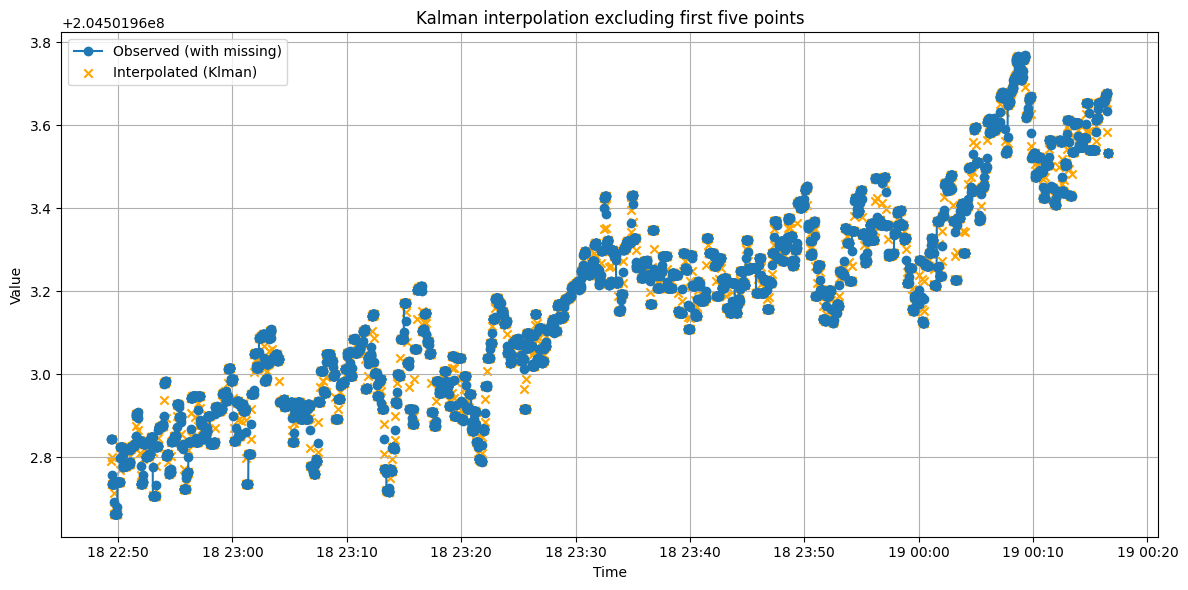

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(Al_shift_expanded[4:], label='Observed (with missing)', marker='o', linestyle='-')
#plt.plot(Al_shift_final[4:], label='Interpolated (Kalman)', linestyle='--')
plt.scatter(Al_shift_final[4:].index, Al_shift_final[4:], label='Interpolated (Klman)', marker = 'x', c = 'orange') 
plt.legend()
plt.title('Kalman interpolation excluding first five points')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Results 

The following code produces the same summary statistics from Kalman filter interpolation to compare with those from time-based linear interpolation presented earlier.

In [41]:
nuAl = [Decimal(i) for i in comb['nuAl']]
nuSr = [Decimal(i) for i in comb['nuSr']]
nuYb = [Decimal(i) for i in comb['nuYb']]

shiftAl = [Decimal(i) for i in Al_shift_final]
shiftSr = [Decimal(i) for i in Sr_shift_final]
shiftYb = [Decimal(i) for i in Yb_shift_final]

frequency_Al_ErYb_KF = [((i + j) * total_correction_Al).iloc[0] for i, j in zip(nuAl[10:], shiftAl[10:])]
frequency_Sr_ErYb_KF = [((i + j) * total_correction_Sr).iloc[0] for i, j in zip(nuSr[10:], shiftSr[10:])]
frequency_Yb_ErYb_KF = [((i + j) * total_correction_Yb).iloc[0] for i, j in zip(nuYb[10:], shiftYb[10:])]

frequency_ratio_ErYb1_KF = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb_KF, frequency_Sr_ErYb_KF)]
frequency_ratio_ErYb2_KF = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb_KF, frequency_Sr_ErYb_KF)]
frequency_ratio_ErYb3_KF = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb_KF, frequency_Yb_ErYb_KF)]

print("Al+/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_KF)))
print("Yb/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_KF)))
print("Al+/Yb ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_KF)), '\n')

clean_frequency_ratio_ErYb1_KF = clean_frequency_ratio(frequency_ratio_ErYb1_KF)
clean_frequency_ratio_ErYb2_KF = clean_frequency_ratio(frequency_ratio_ErYb2_KF)
clean_frequency_ratio_ErYb3_KF = clean_frequency_ratio(frequency_ratio_ErYb3_KF)

print("Al+/Sr ADEV with tau=", math.floor(len(clean_frequency_ratio_ErYb1_KF)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb1_KF, math.floor(len(clean_frequency_ratio_ErYb1_KF)/3)).sqrt()))
print("Yb/Sr ADEV with tau=", math.floor(len(clean_frequency_ratio_ErYb2_KF)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb1_KF, math.floor(len(clean_frequency_ratio_ErYb2_KF)/3)).sqrt())) 
print("Al+/Yb ADEV with tau=", math.floor(len(clean_frequency_ratio_ErYb3_KF)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb3_KF, math.floor(len(clean_frequency_ratio_ErYb1_KF)/3)).sqrt()))

Al+/Sr ratio offset from BACON paper -7.5956E-16
Yb/Sr ratio offset from BACON paper -8.0453E-16
Al+/Yb ratio offset from BACON paper -1.5600E-17 

Al+/Sr ADEV with tau= 1384 :  5.5648E-17
Yb/Sr ADEV with tau= 1273 :  5.5782E-17
Al+/Yb ADEV with tau= 1515 :  6.6042E-18
